### Heart Disease Prediction with KNN Classifier


Columns
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular - hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

https://www.kaggle.com/competitions/heart-disease-prediction-dataquest/data

#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#%matplotlib inline


In [5]:
# file_path = r'C:\Users\patsy\Downloads\heart_disease_prediction_kaggle.csv'
file_path = r'C:\Users\patsy\Desktop\My Folder\PRACTICE- HTML, CSS, JAVASCRIPT, PYTHON CODES\Data Analysis - Excel Tutorial materials\Data_practice\heart_disease_prediction_kaggle.csv'
heart_pred = pd.read_csv(file_path)
heart_pred.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


#### Exploratory Analysis (exploring the dataset)

In [6]:
heart_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
heart_pred.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


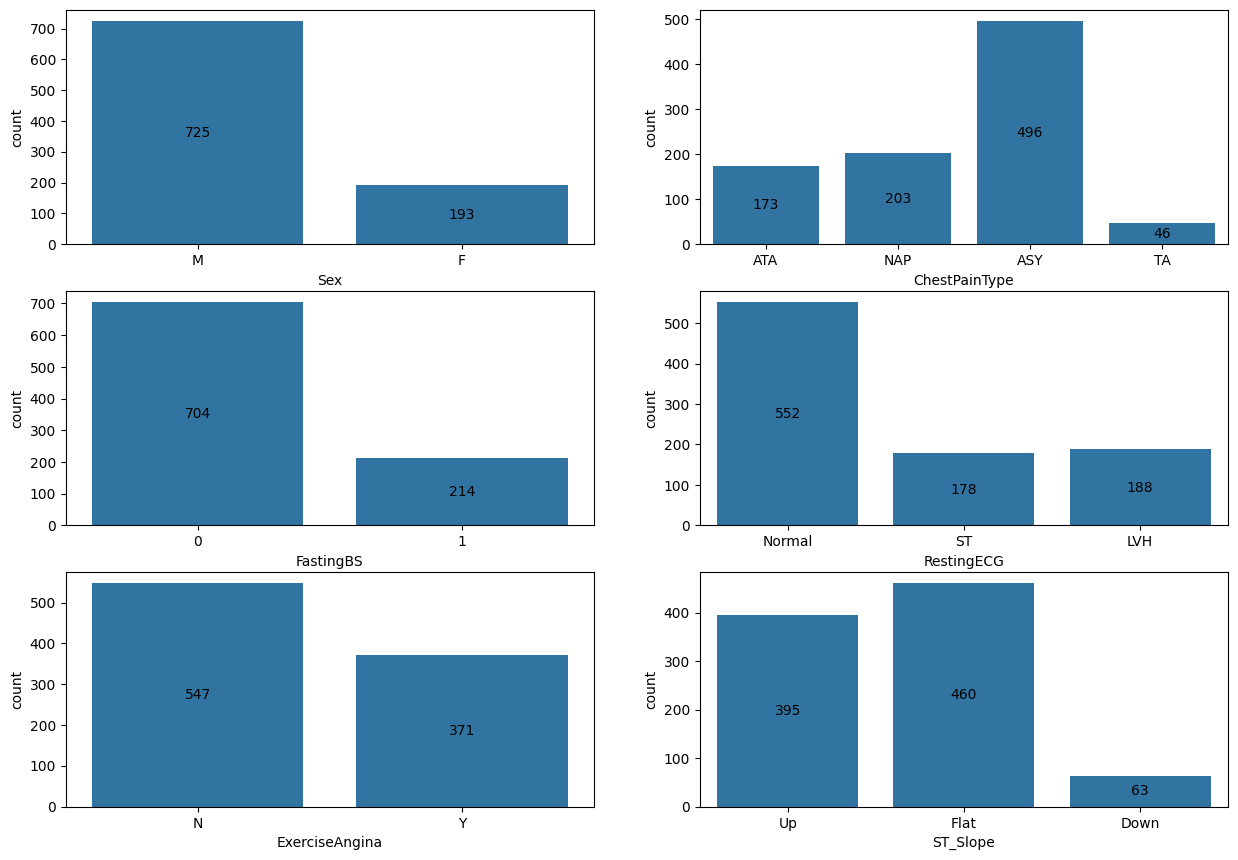

In [10]:
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
fig = plt.figure(figsize=(15, 14))

for idx, col in enumerate (categorical_cols):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=heart_pred[col], ax=ax)
    #include data labels
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

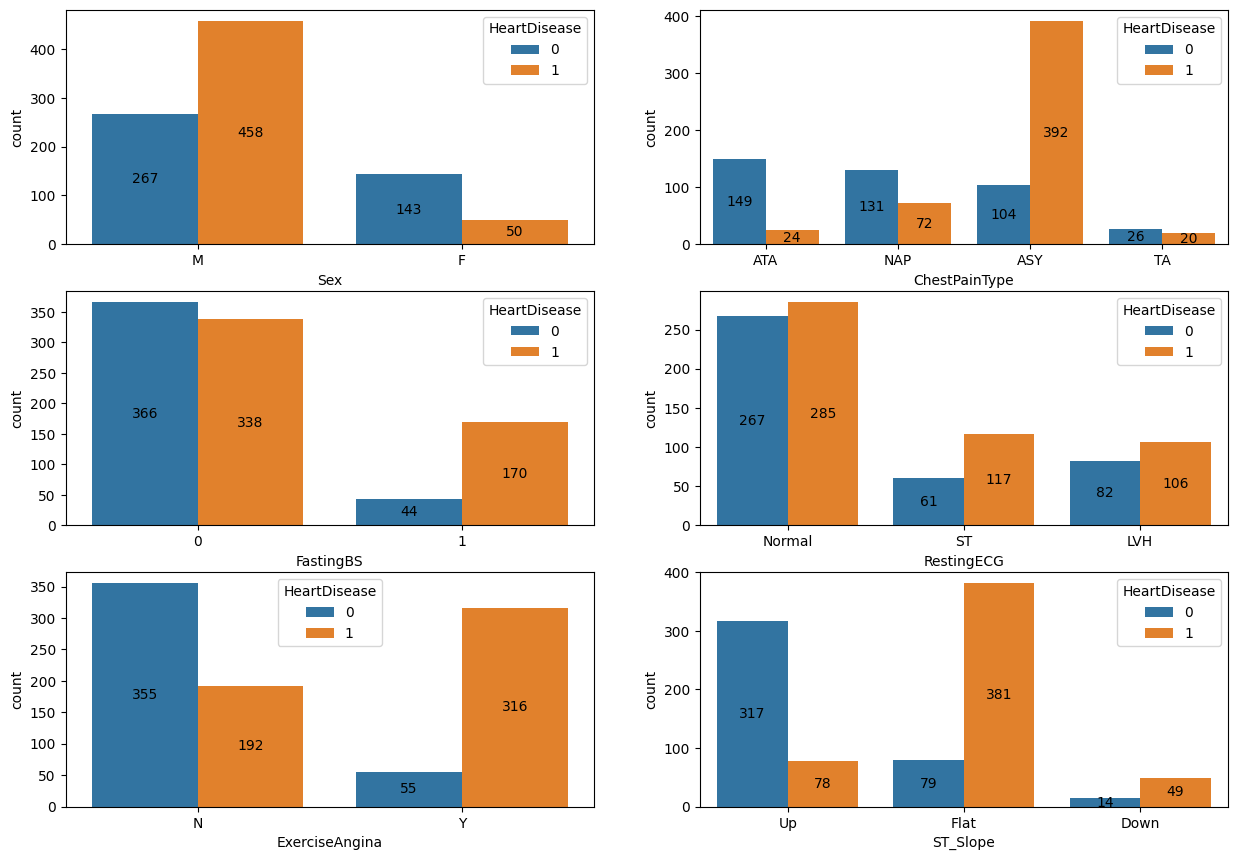

In [14]:

fig = plt.figure(figsize=(15, 14))

for idx, col in enumerate (categorical_cols):
# for idx, col in enumerate (categorical_cols[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by heart disease
    sns.countplot(x=heart_pred[col], hue=heart_pred['HeartDisease'], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

#### Data Cleaning

In [16]:
heart_pred_clean = heart_pred.copy()

heart_pred_clean = heart_pred_clean[heart_pred_clean["RestingBP"] != 0]
heartdisease_mask = heart_pred_clean["HeartDisease"] == 0

cholesterol_without_heartdisease = heart_pred_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = heart_pred_clean.loc[~heartdisease_mask, "Cholesterol"]

heart_pred_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace=0, value=cholesterol_without_heartdisease.median())
heart_pred_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace=0, value=cholesterol_with_heartdisease.median())

In [17]:
heart_pred_clean[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


##### Now we are going to convert categorical variables to numeric variables 

In [18]:
heart_pred_clean = pd.get_dummies(heart_pred_clean, drop_first=True)
heart_pred_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


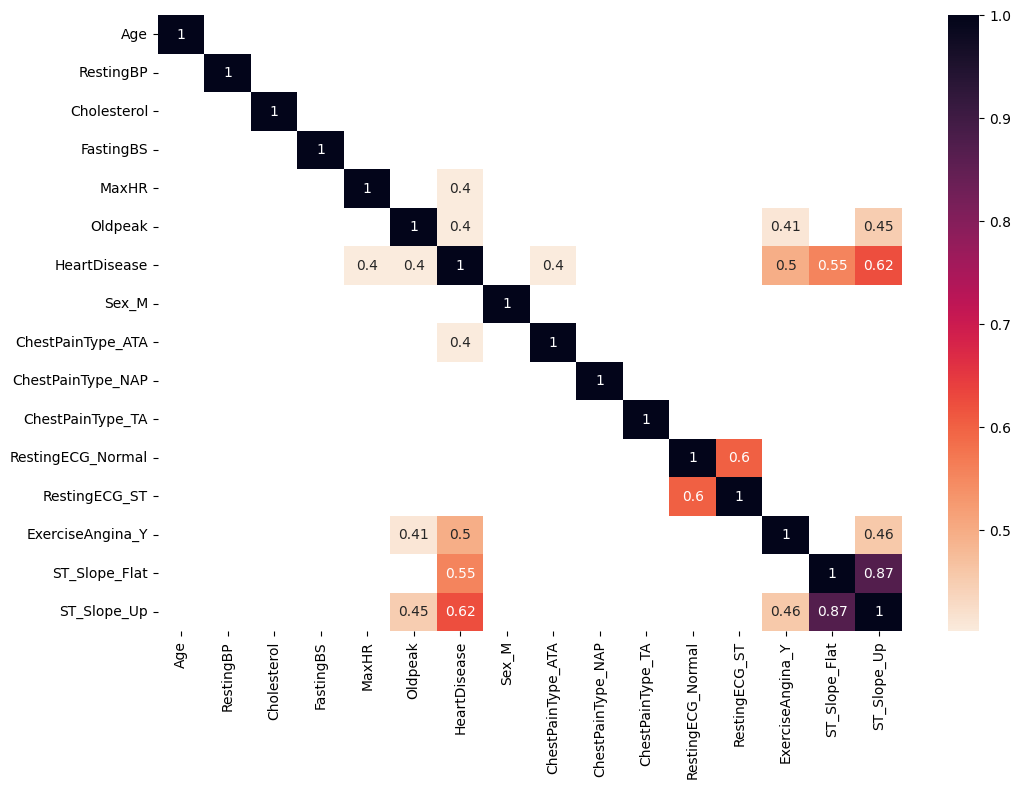

In [24]:
correlations = abs(heart_pred_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations [correlations > 0.40], annot=True, cmap='rocket_r')
plt.show()

### Splitting train and test sets

In [26]:
X = heart_pred_clean.drop (["HeartDisease"], axis = 1)
y = heart_pred_clean ["HeartDisease"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=417)

features = [
    "MaxHR",
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up",
]

for feature in features:
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print (f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy * 100:.2f}%")

The k-NN classifier trained on MaxHR and with k = 3 has an accuracy of 55.07%
The k-NN classifier trained on Oldpeak and with k = 3 has an accuracy of 58.70%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 61.59%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 73.19%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 81.88%
The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 55.07%


In [27]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print (f"Accuracy: {accuracy * 100:.2f}")

Accuracy: 83.33


#### Refactoring the paramenters and model

In [ ]:
X = heart_pred_clean.drop (["HeartDisease"], axis = 1)
y = heart_pred_clean ["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=417)

features = [
    "MaxHR",
    "Oldpeak",
    # "Sex_M",  #just to check the perfomance of the parameters with this included
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up",
]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_train_scaled

array([[0.78169014, 0.42682927, 0.        , 0.        , 1.        ],
       [0.46478873, 0.42682927, 1.        , 1.        , 0.        ],
       [0.71126761, 0.48780488, 0.        , 1.        , 0.        ],
       ...,
       [0.26056338, 0.51219512, 1.        , 0.        , 1.        ],
       [0.15492958, 0.19512195, 0.        , 0.        , 1.        ],
       [0.59859155, 0.63414634, 0.        , 1.        , 0.        ]])

In [ ]:
grid_params = {"n_neighbors": range (1, 20),
                "metric": ["minkowski", "manhattan"]
                }
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train);

# you can remove the semi-colon and run it as normal

In [ ]:
# shows the best metric for optimizing your model/features

knn_grid.best_score_ * 100, knn_grid.best_params_

(82.66749379652605, {'metric': 'manhattan', 'n_neighbors': 19})

In [33]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print (f" Model Accuracy on test set: {accuracy * 100:.2f}")

 Model Accuracy on test set: 82.61


In [34]:
# Checking data distribution since test was better than training results

print ("Distribution of patients by their sex in the entire dataset")
print (X.Sex_M.value_counts())

print ("\nDistribution of patients by their sex in the training dataset")
print (X_train.Sex_M.value_counts())

print ("\nDistribution of patients by their sex in the test dataset")
print (X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
Sex_M
True     724
False    193
Name: count, dtype: int64

Distribution of patients by their sex in the training dataset
Sex_M
True     615
False    164
Name: count, dtype: int64

Distribution of patients by their sex in the test dataset
Sex_M
True     109
False     29
Name: count, dtype: int64


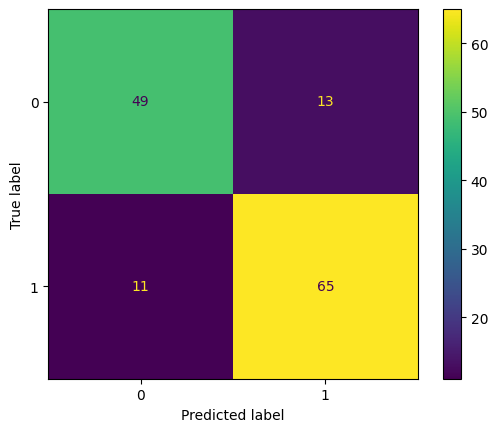

In [ ]:
# This helps diagnose the extent the model is doing in general in predicting 

cf = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cf).plot()
plt.show()